# Using scDALI - Example on synthetic data

In this example we will generate artificial data, test for dependencies and approximate the DALI generative model to estimate the allelic rates for each cell.

In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from scdali import run_tests, run_interpolation
from scdali.utils import simulate
from scdali.utils.stats import apply_fdr_bh, compute_quantile_diff

## Data simulation

We start by simulating a cell state matrix. For this toy example we assume a one-dimensional cell state. The latent rates will be sampled from a Gaussian process with RBF kernel matrix.

In [4]:
n_cells = 500
n_regions = 25

In [5]:
cell_state = np.linspace(0, 1, n_cells)
K = simulate.create_rbf_kernel(cell_state, lengthscale=.8) + 1e-9 * np.eye(n_cells)

Simulate total counts from a Poisson model.

In [6]:
D = np.random.default_rng(42).poisson(lam=5, size=(cell_state.shape[0], n_regions)) + 1

We now draw from the scDALI model, a Gaussian process model with Beta-Binomial likelihood. 

In [7]:
sim = simulate.simulate_beta_binomial(K=K, D=D, sigma2=0.4, theta=1, mu=.01, seed=123)
A = sim['A']

Let's look at an example.

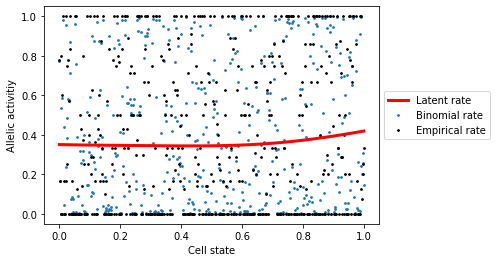

In [8]:
fig, ax = plt.subplots()
ax.plot(cell_state, sim['beta_mean'][:, 0], label='Latent rate', c='r', linewidth=3)
ax.scatter(cell_state, sim['binomial_mean'][:, 0], label='Binomial rate', s=3)
ax.scatter(cell_state, A[:, 0] / D[:, 0], label='Empirical rate', c='k', s=3)
ax.set(xlabel='Cell state', ylabel='Allelic activitiy')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

## Testing

To test for allele-specific effects, scDALI offers a high-level interface. Implemented are tests for
- heterogeneous imblance across the cell state space (scDALI-Het)
- homogeneous or constant imbalance (scDALI-Hom) 
- any kind of imbalance (scDALI-Joint)

In [9]:
pvals_het = run_tests(A=A, D=D, cell_state=cell_state, model='scDALI-Het')['pvalues']

[scdali] Processing 25 regions on 1 core(s) ... 


100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 56.96it/s]


In [10]:
res_joint = run_tests(A=A, D=D, cell_state=cell_state, model='scDALI-Joint', base_rate=.5)

[scdali] Processing 25 regions on 1 core(s) ... 


  0%|                                                                                          | 0/25 [00:00<?, ?it/s]/Users/tobi/miniconda3/envs/scdali/lib/python3.8/site-packages/chiscore/_optimal.py:166: RuntimeWarning: divide by zero encountered in true_divide
  temp = (pmin_q - temp1) / (1 - r_all)
100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [00:29<00:00,  1.18s/it]


In [11]:
pvals_hom = run_tests(A=A, D=D, model='scDALI-Hom', base_rate=.5)['pvalues']

[scdali] Processing 25 regions on 1 core(s) ... 


100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.18it/s]


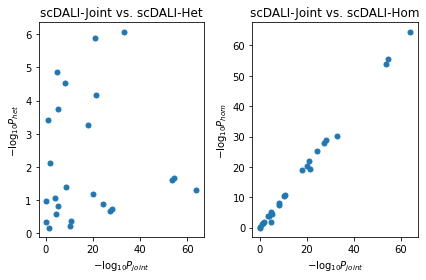

In [12]:
fig, axes = plt.subplots(1, 2)
ax = axes[0]
p = ax.scatter(-np.log10(res_joint['pvalues']), -np.log10(pvals_het), vmin=0, vmax=1, s=25)
ax.set(ylabel=r'$-\log_{10} P_{het}$', xlabel=r'$-\log_{10} P_{joint}$', title='scDALI-Joint vs. scDALI-Het')

ax = axes[1]
p = ax.scatter(-np.log10(res_joint['pvalues']), -np.log10(pvals_hom), vmin=0, vmax=1, s=25)
ax.set(ylabel=r'$-\log_{10} P_{hom}$', xlabel=r'$-\log_{10} P_{joint}$', title='scDALI-Joint vs. scDALI-Hom')

plt.tight_layout()

Apply Benjamini-Hochberg to control FDR.

In [13]:
pvals_corrected = apply_fdr_bh(pvals_het)

## Estimation and visualization of allelic rates

Having identified a set of significantly variable regions, we can estimate the latent rates using a Gaussian process (GP) model. scDALI offers a wrapper around gpflow to train a sparse GP model. The estimated latent rates can be used for visualization and effect size computation.

In [14]:
significant = np.where(pvals_corrected < .1)[0]
significant

array([ 2,  3,  5,  6, 12, 15, 16, 17, 18, 20, 22, 23, 24])

In [15]:
gp_results = run_interpolation(
    A=A[:, significant],
    D=D[:, significant],
    cell_state=cell_state,
)

[scdali] Processing 13 regions on 1 core(s) ... 


  0%|                                                                                          | 0/13 [00:00<?, ?it/s]2022-01-06 14:16:06.423780: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-06 14:16:06.455017: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [00:26<00:00,  2.01s/it]


Let's again look at an example.

In [16]:
i = 0
region = significant[i]

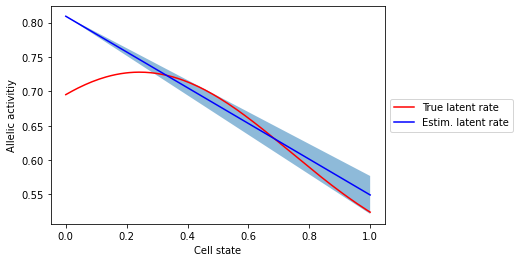

In [17]:
mu = gp_results['posterior_mean'][:, i]
sd = np.sqrt(gp_results['posterior_var'][:, i])

fig, ax = plt.subplots()
ax.plot(cell_state, sim['beta_mean'][:, region], label='True latent rate', c='r')
ax.plot(cell_state, mu, label='Estim. latent rate', c='b')
ax.fill_between(cell_state, mu-sd, mu+sd, alpha=.5)
ax.set(xlabel='Cell state', ylabel='Allelic activitiy')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

To determine effect sizes, we compute the difference between the top and bottom quantiles for the estimated latent rates (Qdiff10)

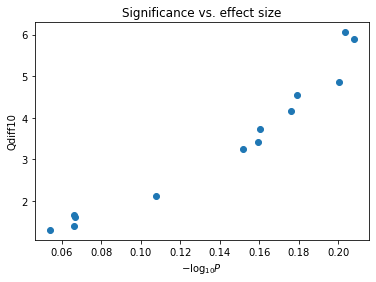

In [18]:
Qdiff10 = compute_quantile_diff(gp_results['posterior_mean'], .10)

fig, ax = plt.subplots()
ax.scatter(Qdiff10, -np.log10(pvals_het[significant]))
ax.set(xlabel=r'$-\log_{10} P$', ylabel='Qdiff10', title='Significance vs. effect size');